#Hugging Face practice

Name: Raul Catacora Grundy

email: rcatagrundy@gmail.com

repository: https://github.com/Cerpint4xt/NLP_Omdena

## Load and Process dataset

In [1]:
!pip install -q datasets

In [2]:
from datasets import load_dataset

In [3]:
emotions = load_dataset('emotion', trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_set = emotions["train"]
train_set

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
train_set[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [8]:
def label_converter(row):
    return emotions["train"].features["label"].int2str(row)

In [9]:
df["label_name"] = df["label"].apply(label_converter)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

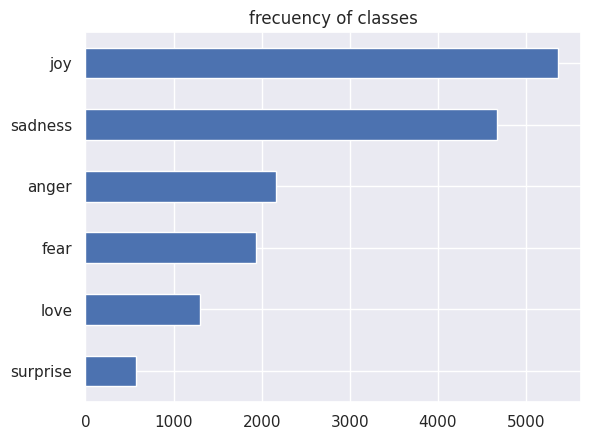

In [11]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("frecuency of classes")
plt.show()

In [12]:
emotions.reset_format()

## Data preprocessing
### Tokenization with Hugging Face

In [13]:
!pip install -q transformers

In [14]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [15]:
print(tokenize_function(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [16]:
tokenized_dataset = emotions.map(tokenize_function, batched = True, batch_size= None)

In [17]:
print(tokenized_dataset["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## Building de model

In [18]:
from transformers import AutoModelForSequenceClassification
import torch

checkpoint = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = (AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=6).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [20]:
from huggingface_hub import notebook_login
notebook_login()

In [21]:
!pip install accelerate

In [22]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir = "finetuning-emotion-model",
    num_train_epochs = 2,
    learning_rate = 2e-5,
    per_device_eval_batch_size=64,
    per_device_train_batch_size=64,
    weight_decay = 0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    push_to_hub = True
)

In [23]:
from transformers import Trainer

trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = tokenized_dataset["train"],
    eval_dataset = tokenized_dataset["validation"],
    tokenizer = tokenizer
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [24]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.327179,0.900500,0.898951
2,0.550300,0.222437,0.924500,0.924656


TrainOutput(global_step=500, training_loss=0.5502777709960938, metrics={'train_runtime': 243.6298, 'train_samples_per_second': 131.347, 'train_steps_per_second': 2.052, 'total_flos': 720342861696000.0, 'train_loss': 0.5502777709960938, 'epoch': 2.0})

In [25]:
trainer.push_to_hub(commit_message= "First fine tuning on a model")

events.out.tfevents.1711403367.5a9a6059fa40.2290.0:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/cerpintaxt/finetuning-emotion-model/commit/4162ca3dd4959020904567f2c43a5e87d20884f0', commit_message='First fine tuning on a model', commit_description='', oid='4162ca3dd4959020904567f2c43a5e87d20884f0', pr_url=None, pr_revision=None, pr_num=None)

In [27]:
from transformers import pipeline

classifier = pipeline("text-classification", model="cerpintaxt/finetuning-emotion-model")

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [28]:
pred = classifier(["I love this move and it is really good"], return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


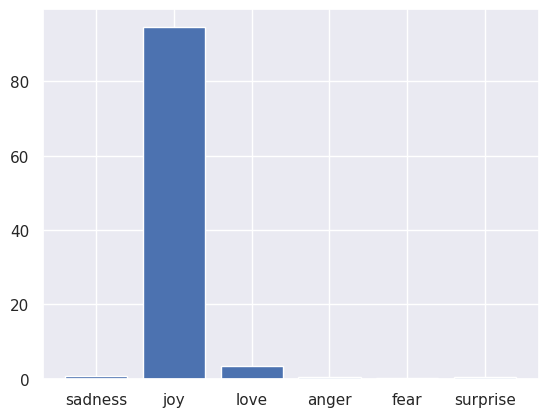

In [30]:
import pandas as pd

labels = emotions["train"].features["label"].names
df = pd.DataFrame(pred[0])
plt.bar(labels, 100* df["score"])
plt.show()